In [30]:
import json
import pandas as pd
from konlpy.tag import Okt # komoran, han, kkma
from jamo import h2j, j2hcj
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tqdm.notebook import tqdm
import numpy as np

# 데이터 가져오기, 학습 데이터셋으로 만들기

In [11]:
imm = pd.read_csv(r'data\immoral.txt', sep = 'asssssssss', header = None)
imm.columns = ['text']
imm['immoral'] = True

C:\Users\user\AppData\Local\Temp\ipykernel_8064\2104182851.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imm = pd.read_csv(r'data\immoral.txt', sep = 'asssssssss', header = None)


In [14]:
cl = pd.read_csv(r'data\clean.txt', sep = 'asssssssss', header = None)
cl.columns = ['text']
cl['immoral'] = False
cl

C:\Users\user\AppData\Local\Temp\ipykernel_8064\3891659705.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cl = pd.read_csv(r'data\clean.txt', sep = 'asssssssss', header = None)


,text,immoral
0,그럼 내가 못봤을 수도 있으니 누가 들어갔는지 알려주셈,False
1,캡쳐해서 인벤에 박제해야지,False
2,베인이 욕심부려서 못밀은거잖아,False
3,어디서 내가 욕심을 부렸는데?,False
4,내가 핑을 쳤어 뭘했어?,False
...,...,...
265,역시 팅ㅇ기신거였네요,False
266,화이팅,False
267,ㅎㅇㅎㅇ,False
268,고소장ㄱㄱ,False


In [25]:
cmp = pd.read_csv(r'data\champions.csv')
cmp.columns = ['text','immoral']
cmp.loc[cmp['immoral'] == 0, 'immoral'] = False
cmp.loc[cmp['immoral'] == 1, 'immoral'] = True
cmp

C:\Users\user\AppData\Local\Temp\ipykernel_8064\1373877507.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cmp.loc[cmp['immoral'] == 0, 'immoral'] = False


,text,immoral
0,얘 와맆에 곰돌이가 에어본 시키는 거 생겼던데 여기에도 생기나,False
1,자기고향 찾아오네,False
2,몇달만의 고향이냐,False
3,점멸 있을 때 한정 1티어,False
4,스킬 사거리 표시 없이 하면 암걸리는 챔,False
...,...,...
6458,클레드로 굶드라랑 월식 못 가게 너프먹는다니까 진짜 ㅈ같아서 겜 못해먹겠네 월식은 ...,True
6459,진짜 개사기임아니 협곡말고 롤체 학살자 클레드요,False
6460,진짜 태불방 롤백 시킬거 아니면 클레드는 건들면 안되지 ㅋㅋㅋ 선넘네 진짜,False
6461,"""바텀에서 겨우 더블킬을 했다.""""나팔소리가 들렸다.""""여름이었다.""(제압되었습니다!)",False


In [ ]:
# ai hub train set
li = []
for i in range(1, 6):
    with open(r'.\data\train\labled\talksets-train-' + str(i) + '.json') as f:
        data = json.load(f)
    for d in data:
        for s in d['sentences']:
            li.append([s['origin_text'], s['is_immoral'], s['intensity'], 
                    'CENSURE' in s['types'], 'HATE' in s['types'], 'DISCRIMINATION' in s['types'], 
                    'SEXUAL' in s['types'], 'ABUSE' in s['types'], 'VIOLENCE' in s['types'], 'CRIME' in s['types']])
            
train = pd.DataFrame(li, columns=['text', 'immoral', 'intensity', 'CENSURE', 'HATE', 'DISCRIMINATION', 'SEXUAL', 'ABUSE', 'VIOLENCE', 'CRIME'])
train['text'] = train['text'].apply(lambda x : re.sub('#@.+?#', '', x.replace('#@#', '')))

train['immoral'] = (train['SEXUAL'] == True) | (train['ABUSE'] == True)
train_set = train[['text', 'immoral']]

In [16]:
train_set

,text,immoral
0,부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네,False
1,맞아. 사람들이 진짜 개념이없다,False
2,저렇게는 살지 말아야지,False
3,그러게 게으르고 멍청한 사람들은 맞아야해,False
4,인방 보는 남자는 거르는게 맞다,False
...,...,...
363149,뷔응신처럼 죽지도 못하면서 괜히 뛰어들기는,False
363150,오죽 하면 그러겠나,False
363151,너 얼굴 보면 한숨 나온다.,False
363152,신경 끄세요.,False


In [ ]:
# ai hub test set
li = []
with open(r'.\data\valid\labled\talksets-train-6.json') as f:
    data = json.load(f)
for d in data:
    for s in d['sentences']:
        li.append([s['origin_text'], s['is_immoral'], s['intensity'], 
                'CENSURE' in s['types'], 'HATE' in s['types'], 'DISCRIMINATION' in s['types'], 
                'SEXUAL' in s['types'], 'ABUSE' in s['types'], 'VIOLENCE' in s['types'], 'CRIME' in s['types']])
test = pd.DataFrame(li, columns=['text', 'immoral', 'intensity', 'CENSURE', 'HATE', 'DISCRIMINATION', 'SEXUAL', 'ABUSE', 'VIOLENCE', 'CRIME'])

test['text'] = test['text'].apply(lambda x : re.sub('#@.+?#', '', x.replace('#@#', '')))

test['immoral'] = (test['SEXUAL'] == True) | (test['ABUSE'] == True)
test_set = test[['text', 'immoral']]

In [15]:
test_set

,text,immoral
0,명절이면 좀 일찍 마쳐주지,False
1,원래 틀딱들은 눈치가 없어서 ㅋㅋㅋ,False
2,저 나이 먹고 저렇게 눈치 없는 것도 재주다,False
3,요즘은 왜 미세먼지가 별로 없지?,False
4,호주랑 중국이랑 싸우고 있어서 중국에서 호주산석탄을 수입 안해서 그렇대,False
...,...,...
45210,저 여자는 오늘도 레깅스 입네,False
45211,남자 아래에 깔려서 당하고 싶은건가?,False
45212,"휴유, 내가 봐준다 뒷태가 끝내주는데!",False
45213,저정도면 놀아달라는 거 아닌가? 저 라인봐봐 만지면 으스러지겠어,True


In [25]:
# badwords, train
with open(r"C:\code\skkukdt_minzy\DeepLearning\data\train\labled\badwords.json") as f:
    data = json.load(f)

badwords = pd.DataFrame(data['badwords'], columns= ['text'])
badwords['immoral'] = True
train_set = pd.concat([train_set, badwords], ignore_index=True)
train_set

,text,immoral
0,부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네,False
1,맞아. 사람들이 진짜 개념이없다,False
2,저렇게는 살지 말아야지,False
3,그러게 게으르고 멍청한 사람들은 맞아야해,False
4,인방 보는 남자는 거르는게 맞다,False
...,...,...
365081,쎾,True
365082,쏐,True
365083,쒝,True
365084,쒞,True


In [30]:
# train_set.to_csv(r'data/train_set.csv', index = False)
train_set = pd.read_csv(r'data/train_set.csv')
# test_set.to_csv(r'data/test_set.csv', index = False)
test_set = pd.read_csv(r'data/test_set.csv')

In [106]:
pd.read_csv(r'data/train_merge.csv')

,text,immoral
0,부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네,1
1,맞아. 사람들이 진짜 개념이없다,1
2,저렇게는 살지 말아야지,1
3,그러게 게으르고 멍청한 사람들은 맞아야해,1
4,인방 보는 남자는 거르는게 맞다,1
...,...,...
369818,얘 e는 아크샨 궁 마냥 미니언 챔피언 구조믈이 대신 맞아준다거나 하는 변수가 안...,0
369819,얘하면서 계속 느끼는건데 e언제 써야 상대 죽는지좀 보였음 좋겠음아크샨 궁처럼절때 ...,1
369820,롤체마냥 바꾸면 1티어ㄱㄴ,0
369821,브실에서 얘 픽하고 잘하는 얘 거의 본적이 없다 특히 탑,0


In [55]:
# train.to_csv(r'data/train_merge.csv', index = False)
train = pd.read_csv(r'data/train_merge.csv')
# test.to_csv(r'data/test_merge.csv', index = False)
test = pd.read_csv(r'data/test_merge.csv')

## op.gg 데이터 크롤링

In [31]:
import requests
from bs4 import BeautifulSoup
import json
import time

In [ ]:
lii = []
headers = {
    'Referer':'https://www.op.gg/',
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36'
}
for chm in champ:
    n = 1
    while 1:
        url = f'https://op.gg/api/v1.0/internal/bypass/champions/{chm}/comments?&sort=popular&page={n}&limit=100&hl=ko_KR&is_latest_version=false'
        n += 1
        resp = requests.get(url, headers = headers)
        dict_ch = json.loads(resp.text)
        if len(dict_ch['data']) == 0:
            break
        
        for dat in dict_ch['data']:
            lii.append(dat['content'].replace('\n', ''))
        time.sleep(5)
    
    print(chm)

In [75]:
df_lii = pd.DataFrame(lii, columns = ['text'])
df_lii['immoral'] = ''
df_lii

,text,immoral
0,얘 와맆에 곰돌이가 에어본 시키는 거 생겼던데 여기에도 생기나,
1,자기고향 찾아오네,
2,몇달만의 고향이냐,
3,점멸 있을 때 한정 1티어,
4,스킬 사거리 표시 없이 하면 암걸리는 챔,
...,...,...
7968,의외로 꼴짤이 별로 없음,
7969,나피리 근데 초반 라인전도 약하고 카운터도 많음.그리고 돌진기가 다른 암살자와 다르...,
7970,0/6/0 야스오:야이 개쌔꺄 이게 챔이냐 야발4/0/2 나피리:개 맞는데0/8/0...,
7971,얘 한테 지면 사람아닌래끼다버프좀 하고 성능좀 버프히라못 쓸 정도다,


In [81]:
# df_lii.to_csv(r'data/champions.csv', index = False)
df_lii = pd.read_csv(r'data/champions.csv')

## 데이터 자모음으로 쪼개기

In [56]:
train['text'] = train['text'].apply(lambda x : j2hcj(h2j(x)))
test['text'] = test['text'].apply(lambda x : j2hcj(h2j(x)))

In [60]:
train_list_2 = []
for a_t in train_list:
    train_list_2.append(list(a_t))

test_list_2 = []
for a_t in test_list:
    test_list_2.append(list(a_t))

# 데이터 전처리


In [81]:
def textToList(text):
    li = []
    for t in text:
        li.append(list(t.strip()))
    return li

In [82]:
# 자모음 쪼갠 텍스트를 한글자씩 리스트로 만들어서 데이터셋 만든다
def textToList(text):
    li = []
    for t in text:
        li.append(list(t))
    return li

X_train = textToList(train['text'])
y_train = train['immoral']

X_test = textToList(test['text'])
y_test = test['immoral']

# X_train.shape, y_train.shape, X_test.shape, y_test.shape

c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

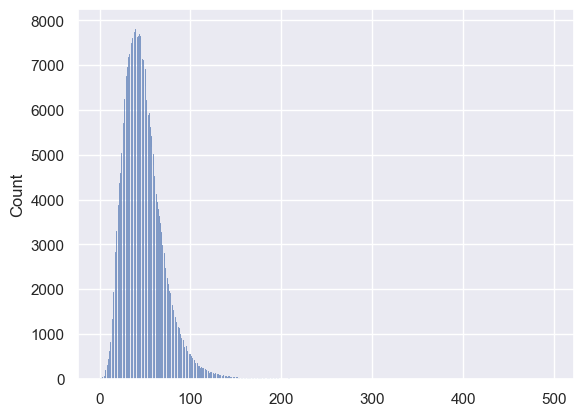

In [83]:
# 문장 최대 길이 정해야되니까 문장 길이 분포가 얼마나 되어있는지 확인한다
li_len = []
for t in X_train:
    li_len.append(len(t))
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(li_len)
## 100으로 자르면 문장 잘리는 아이들 비율이 2%

In [86]:
tokenizer = Tokenizer(num_words=110)
tokenizer.fit_on_texts(X_train) # 단어 인덱스 구축
text_sequences = tokenizer.texts_to_sequences(X_train) # 문자열 -> 인덱스 리스트
                                                            # '나는 천재다 나는 멋있다' -> [1, 2, 1, 3]
# train data로 fit 시켜준 tokenizer로 test data도 인덱스로 변경
text_sequences_test = tokenizer.texts_to_sequences(X_test)

word_vocab = tokenizer.word_index # 딕셔너리 형태
print("전체 단어 개수: ", len(word_vocab)) # 전체 단어 개수 확인

전체 단어 개수:  166


In [90]:
MAX_SEQUENCE_LENGTH = 100 # 문장 최대 길이

X_train = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre') # 문장의 길이가 100 글자가 넘어가면 자르고, 모자르면 0으로 채워 넣는다.
y_train = np.array(y_train) # 각 리뷰의 감정을 넘파이 배열로 만든다.

X_test = pad_sequences(text_sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre') # 문장의 길이가 100 글자가 넘어가면 자르고, 모자르면 0으로 채워 넣는다.
y_test = np.array(y_test) # 각 리뷰의 감정을 넘파이 배열로 만든다.

print('Shape of train input data tensor:', X_train.shape) # 리뷰 데이터의 형태 확인
print('Shape of train label tensor:', y_train.shape) # 감정 데이터 형태 확인
print('Shape of test input data tensor:', X_test.shape) # 리뷰 데이터의 형태 확인
print('Shape of test label tensor:', y_test.shape) # 감정 데이터 형태 확인

Shape of train input data tensor: (369823, 100)
Shape of train label tensor: (369823,)
Shape of test input data tensor: (45972, 100)
Shape of test label tensor: (45972,)


In [127]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras import layers, models

embedding_dim = 100 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = Sequential()
model.add(Embedding(len(word_vocab)+1, 50))
model.add(Conv1D(256, kernel_size, padding='valid', activation='relu'))
model.add(Conv1D(256, kernel_size, padding='valid', activation='relu'))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics=['accuracy'])
# 이진 분류이므로 손실함수는 binary_crossentropy 사용, 에폭마다 정확도를 보기 위해 accuracy 적용
model.summary()

model.save('conv2.h5')

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 50)          8350      
                                                                 
 conv1d_30 (Conv1D)          (None, None, 256)         38656     
                                                                 
 conv1d_31 (Conv1D)          (None, None, 256)         196864    
                                                                 
 conv1d_32 (Conv1D)          (None, None, 256)         196864    
                                                                 
 global_max_pooling1d_17 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                     

In [128]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, epochs= 100, batch_size = 100, validation_split=0.2, callbacks=[early])

'''
Epoch 1/100
2959/2959 [==============================] - 85s 29ms/step - loss: 0.4980 - accuracy: 0.7572 - val_loss: 0.5319 - val_accuracy: 0.7429
Epoch 2/100
2959/2959 [==============================] - 84s 28ms/step - loss: 0.4407 - accuracy: 0.7985 - val_loss: 0.4882 - val_accuracy: 0.7766
Epoch 3/100
2959/2959 [==============================] - 84s 28ms/step - loss: 0.4262 - accuracy: 0.8069 - val_loss: 0.4740 - val_accuracy: 0.7809
Epoch 4/100
2959/2959 [==============================] - 84s 28ms/step - loss: 0.4182 - accuracy: 0.8126 - val_loss: 0.4689 - val_accuracy: 0.7902
Epoch 5/100
2959/2959 [==============================] - 84s 28ms/step - loss: 0.4135 - accuracy: 0.8157 - val_loss: 0.4698 - val_accuracy: 0.7878
Epoch 6/100
2959/2959 [==============================] - 84s 28ms/step - loss: 0.4100 - accuracy: 0.8177 - val_loss: 0.4785 - val_accuracy: 0.7886
Epoch 7/100
2959/2959 [==============================] - 87s 29ms/step - loss: 0.4075 - accuracy: 0.8200 - val_loss: 0.4665 - val_accuracy: 0.7939
Epoch 8/100
2959/2959 [==============================] - 97s 33ms/step - loss: 0.4059 - accuracy: 0.8215 - val_loss: 0.4727 - val_accuracy: 0.7949
Epoch 9/100
2959/2959 [==============================] - 85s 29ms/step - loss: 0.4055 - accuracy: 0.8214 - val_loss: 0.4982 - val_accuracy: 0.7844
Epoch 10/100
2959/2959 [==============================] - 79s 27ms/step - loss: 0.4055 - accuracy: 0.8222 - val_loss: 0.4914 - val_accuracy: 0.7892
'''
model.save('conv3.h5')

Epoch 1/100
2959/2959 [==============================] - 235s 79ms/step - loss: 0.4988 - accuracy: 0.7562 - val_loss: 0.4771 - val_accuracy: 0.7752
Epoch 2/100
2959/2959 [==============================] - 229s 77ms/step - loss: 0.4357 - accuracy: 0.8023 - val_loss: 0.4600 - val_accuracy: 0.7865
Epoch 3/100
2959/2959 [==============================] - 228s 77ms/step - loss: 0.4202 - accuracy: 0.8119 - val_loss: 0.4604 - val_accuracy: 0.7898
Epoch 4/100
2959/2959 [==============================] - 229s 77ms/step - loss: 0.4165 - accuracy: 0.8157 - val_loss: 0.4753 - val_accuracy: 0.7941
Epoch 5/100
2959/2959 [==============================] - 228s 77ms/step - loss: 0.4165 - accuracy: 0.8169 - val_loss: 0.5035 - val_accuracy: 0.7867


In [108]:
pred_y_train = model.predict(X_train)
print(model.evaluate(pred_y_train, y_train))

pred_y_test = model.predict(X_test)
print(model.evaluate(pred_y_test, y_test))

11557/11557 [==============================] - 72s 6ms/step


ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv1d_24" "                 f"(type Conv1D).
    
    Negative dimension size caused by subtracting 3 from 1 for '{{node sequential_14/conv1d_24/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_14/conv1d_24/Conv1D/ExpandDims, sequential_14/conv1d_24/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,100], [1,3,100,256].
    
    Call arguments received by layer "conv1d_24" "                 f"(type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 100), dtype=float32)


In [119]:
print(model.evaluate(pred_y_train, y_train))

ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\anaconda3\envs\mzp2\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_14" "                 f"(type Sequential).
    
    Input 0 of layer "conv1d_24" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 100)
    
    Call arguments received by layer "sequential_14" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=False
      • mask=None


In [122]:
y_train.shape

(369823,)

In [109]:
model.save('cnn.h5')
# new_model = tf.keras.models.load_model('version1.h5')

1413/1413 [==============================] - 25s 18ms/step


In [91]:
pred_y_train = model.predict(X_train)

11349/11349 [==============================] - 182s 16ms/step


In [83]:
test['pred'] = pred_y
test[['text', 'immoral', 'intensity', 'pred', 'CENSURE', 'HATE', 'DISCRIMINATION',
       'SEXUAL', 'ABUSE', 'VIOLENCE', 'CRIME']]

,text,immoral,intensity,pred,CENSURE,HATE,DISCRIMINATION,SEXUAL,ABUSE,VIOLENCE,CRIME
0,명절이면좀일찍마쳐주지,False,0.0,1.014786,False,False,False,False,False,False,False
1,원래틀딱들은눈치가없어서ㅋㅋㅋ,True,1.4,1.464311,True,True,False,False,False,False,False
2,저나이먹고저렇게눈치없는것도재주다,True,1.0,1.134663,True,False,False,False,False,False,False
3,요즘은왜미세먼지가별로없지?,False,0.0,0.136485,False,False,False,False,False,False,False
4,호주랑중국이랑싸우고있어서중국에서호주산석탄을수입안해서그렇대,False,0.0,0.259939,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
45210,저여자는오늘도레깅스입네,False,0.0,0.382613,False,False,False,False,False,False,False
45211,남자아래에깔려서당하고싶은건가?,True,1.8,1.123744,False,False,False,False,False,True,False
45212,"휴유,내가봐준다뒷태가끝내주는데!",False,0.0,0.525188,False,False,False,False,False,False,False
45213,저정도면놀아달라는거아닌가?저라인봐봐만지면으스러지겠어,True,1.8,1.077605,False,False,False,True,False,False,False


In [95]:
train['pred_imm'] = pred_y_train > 0

<Axes: >

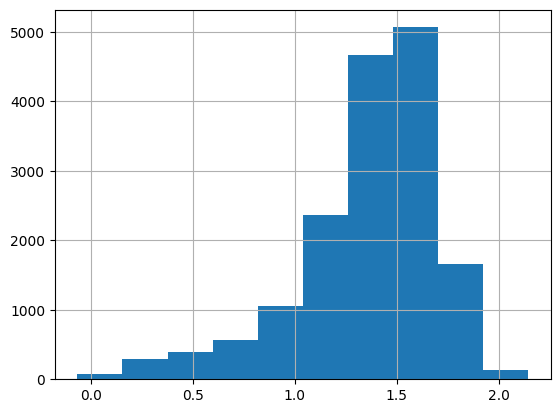

In [94]:
train[train['ABUSE'] ==True]['pred'].hist()

In [105]:

from sklearn.metrics import classification_report

for i in np.arange(0, 1.5, 0.1):
    train['pred_imm'] = pred_y_train > i
    print(i)
    print(classification_report(train['immoral'], train['pred_imm']))
    print('='*25)

0.0
              precision    recall  f1-score   support

       False       0.98      0.02      0.04    162948
        True       0.56      1.00      0.71    200206

    accuracy                           0.56    363154
   macro avg       0.77      0.51      0.37    363154
weighted avg       0.75      0.56      0.41    363154

0.1
              precision    recall  f1-score   support

       False       0.96      0.15      0.26    162948
        True       0.59      1.00      0.74    200206

    accuracy                           0.61    363154
   macro avg       0.78      0.57      0.50    363154
weighted avg       0.76      0.61      0.52    363154

0.2
              precision    recall  f1-score   support

       False       0.93      0.31      0.47    162948
        True       0.64      0.98      0.77    200206

    accuracy                           0.68    363154
   macro avg       0.78      0.65      0.62    363154
weighted avg       0.77      0.68      0.64    363154

0.30000